# Project 2 - Analysis of a Time Series

### Time Series and Forecasting - MIA 2025
#### Project developed for:
##### Daniel Dias
##### Gonçalo Monteiro
##### Gonçalo Brochado
##### Lucas Santiago

In [23]:
import requests
import pandas as pd
from statsmodels.tsa.stattools import ccf
from matplotlib import pyplot as plt


## Collect Data

In [10]:
def fetch_open_meteo_data():
    print("A iniciar a recolha de dados para o Porto (5 Anos)...")

    # --- Configurações ---
    # Coordenadas do Porto, Portugal
    LAT = 41.1579
    LON = -8.6291

    # Período definido no texto
    START_DATE = "2020-11-20"
    END_DATE = "2025-11-20"

    # Nome do ficheiro de saída
    OUTPUT_FILE = "porto_weather_air_quality_5y.csv"

    # --- 1. Obter Dados Meteorológicos (Weather Archive API) ---

    weather_url = "https://archive-api.open-meteo.com/v1/archive"
    weather_params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": START_DATE,
        "end_date": END_DATE,
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "dew_point_2m",
            "apparent_temperature",
            "pressure_msl",
            "surface_pressure",
            "precipitation",
            "rain",
            "snowfall",
            "cloud_cover",
            "cloud_cover_low",
            "cloud_cover_mid",
            "cloud_cover_high",
            "shortwave_radiation",
            "direct_radiation",
            "diffuse_radiation",
            "wind_speed_10m",
            "wind_speed_80m",
            "wind_direction_10m",
            "wind_direction_80m"
        ],
        "timezone": "auto" # Ajusta para o fuso horário do Porto
    }

    try:
        r_weather = requests.get(weather_url, params=weather_params)
        r_weather.raise_for_status()
        weather_json = r_weather.json()

        # Criar DataFrame Meteorológico
        df_weather = pd.DataFrame(weather_json['hourly'])

        # Converter a coluna 'time' para datetime para garantir sincronização
        df_weather['time'] = pd.to_datetime(df_weather['time'])

    except requests.exceptions.RequestException as e:
        print(f"Erro ao descarregar meteo: {e}")
        return

    air_quality_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    air_params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": START_DATE,
        "end_date": END_DATE,
        "hourly": [
            "pm10",
            "pm2_5",
            "carbon_monoxide",
            "nitrogen_dioxide",
            "sulphur_dioxide",
            "ozone",
            "aerosol_optical_depth",
            "dust",
            "uv_index",
            "uv_index_clear_sky",
        ],
        "timezone": "auto"
    }

    try:
        r_air = requests.get(air_quality_url, params=air_params)
        r_air.raise_for_status()
        air_json = r_air.json()

        # Criar DataFrame Qualidade do Ar
        df_air = pd.DataFrame(air_json['hourly'])

        # Converter 'time' para datetime
        df_air['time'] = pd.to_datetime(df_air['time'])

    except requests.exceptions.RequestException as e:
        print(f"Erro ao descarregar qualidade do ar: {e}")
        return

    # Merge baseado na coluna 'time'
    df_final = pd.merge(df_weather, df_air, on="time", how="inner")

    # Reordenar colunas para colocar o tempo primeiro (opcional, mas boa prática)
    cols = ['time'] + [c for c in df_final.columns if c != 'time']
    df_final = df_final[cols]

    # --- 4. Exportar para CSV ---
    df_final.to_csv(OUTPUT_FILE, index=False)

    print("-" * 30)
    print(f"Sucesso! Ficheiro criado: {OUTPUT_FILE}")
    print(f"Início: {df_final['time'].min()}")
    print(f"Fim: {df_final['time'].max()}")
    print(f"Total de registos: {len(df_final)}")
    print("-" * 30)

if __name__ == "__main__":
    fetch_open_meteo_data()

A iniciar a recolha de dados para o Porto (5 Anos)...
------------------------------
Sucesso! Ficheiro criado: porto_weather_air_quality_5y.csv
Início: 2020-11-20 00:00:00
Fim: 2025-11-20 23:00:00
Total de registos: 43848
------------------------------


In [18]:
df_total = pd.read_csv("porto_weather_air_quality_5y.csv")

# Convert timestamp
df_total['time'] = pd.to_datetime(df_total['time'])
df_total = df_total.set_index('time')
df_total = df_total.asfreq("h")

In [19]:
df_total.head(5)

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,cloud_cover,cloud_cover_low,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2020-11-20 00:00:00,14.0,81,10.8,12.7,1031.6,1020.9,0.0,0.0,59,0,...,30.7,19.2,147.0,23.7,1.8,25.0,NaN,6.0,NaN,NaN
2020-11-20 01:00:00,15.3,75,10.8,13.3,1031.0,1020.3,0.0,0.0,0,0,...,30.5,18.2,138.0,21.6,1.8,24.0,NaN,4.0,NaN,NaN
2020-11-20 02:00:00,15.9,72,10.9,13.1,1030.6,1019.9,0.0,0.0,0,0,...,26.1,15.9,134.0,14.0,1.9,27.0,NaN,5.0,NaN,NaN
2020-11-20 03:00:00,15.4,74,10.8,12.3,1030.4,1019.7,0.0,0.0,0,0,...,25.5,13.4,141.0,14.7,1.8,27.0,NaN,3.0,NaN,NaN
2020-11-20 04:00:00,14.6,76,10.4,11.2,1029.9,1019.2,0.0,0.0,0,0,...,24.2,12.8,137.0,12.5,1.8,30.0,NaN,2.0,NaN,NaN


## Missing Values

In [31]:
df_total.isna().sum()
cols_to_drop = [
    "wind_speed_80m",
    "wind_direction_80m",
    "uv_index",
    "uv_index_clear_sky",
    "aerosol_optical_depth"
]
df_total = df_total.drop(columns=cols_to_drop)

## Target and Regressor Selection

### Basead in Literacy

#### 1. Wind Speed (10m)

- *Expected relationship:* wind speed reduces PM2.5

Higher wind speeds increase the dispersion and dilution of fine particles.
Urban studies consistently show a negative correlation between wind and PM2.5.

Reference:

Chen et al. (2020), Atmospheric Pollution Research — wind speed is the strongest negative predictor of PM2.5

#### 2. Relative Humidity

- *Relação esperada:*

    - High humidity → hygroscopic growth of particles → PM2.5 increases
    - Light rain + high humidity → wet deposition → PM2.5 decreases

Relative humidity influences both particle formation and removal processes, making it one of the most relevant physical drivers of particulate matter variability in urban environments.

References:

Seinfeld & Pandis, Atmospheric Chemistry and Physics

Jacobson (2001), Fundamentals of Atmospheric Modelling

#### 3. Temperature

- *Expected relationship:*

    - Low temperature → thermal inversions → pollutant accumulation → PM2.5 increases
    - High temperature → enhanced convection and mixing → PM2.5 decreases

Temperature governs atmospheric stability and boundary-layer height, both of which strongly influence pollutant retention.

Reference:

Kukkonen et al. (2014), Review of PM Formation Under Meteorological Regimes

#### 4. Precipitation

- *Expected relationship:*
Precipitation physically removes particles from the atmosphere via scavenging, leading to lower PM2.5 concentrations.

This is one of the most consistently documented meteorological mechanisms affecting particulate matter.

Reference:

Zhang et al. (2004), Journal of Geophysical Research: detailed study of aerosol scavenging by precipitation.

#### 5. Shortwave Radiation

- *Expected relationship:*

Higher radiation → stronger vertical mixing → PM2.5 decreases

Radiation also affects photochemical reactions and secondary aerosol formation.

Shortwave radiation is therefore a key indicator of atmospheric mixing processes and photochemical regimes.

References:

EPA (2019), Air Quality Criteria Document

Gao et al. (2016), Atmospheric Environment

#### 6. Mean Sea-Level Pressure (MSL)

- *Expected relationship:*

High pressure → stable air masses → pollutant accumulation → PM2.5 increases

Low pressure → dynamic/unstable atmosphere → enhanced dispersion → PM2.5 decreases

Pressure is a proxy for synoptic-scale circulation patterns and thus strongly influences pollution episodes.

Reference:

Wallace & Hobbs, Atmospheric Science: An Introductory Survey

#### 7. Ozone (O₃)

- *Expected relationship:*
High ozone levels indicate strong atmospheric oxidative capacity and photochemical activity, which are directly related to the formation of secondary particulate matter (e.g., nitrates and sulfates).
Ozone is therefore a useful proxy variable for the chemical environment affecting PM2.5 formation.

Reference:

Jimenez et al. (2009), Science: highlights the role of atmospheric oxidation capacity in secondary organic aerosol formation.

In [21]:
target = "pm2_5"

exog_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "pressure_msl",
    "ozone"
]

df = df_total[[target] + exog_vars]

In [22]:
corr = df[[target] + exog_vars].corr()
corr[target].sort_values(ascending=False)

pm2_5                   1.000000
pressure_msl            0.301163
relative_humidity_2m    0.087068
shortwave_radiation    -0.154334
precipitation          -0.158238
temperature_2m         -0.232781
wind_speed_10m         -0.360724
ozone                  -0.442714
Name: pm2_5, dtype: float64

The correlation matrix indicates moderate yet significant connections between meteorological factors and PM2.5.

In environmental time series, significant linear correlations are not anticipated because of the nonlinear, lagged, and multivariate characteristics of atmospheric processes.

The noted correlations (–0.44 for ozone, –0.36 for wind speed, +0.30 for pressure) correspond with figures documented in the literature and represent authentic physical relationships.

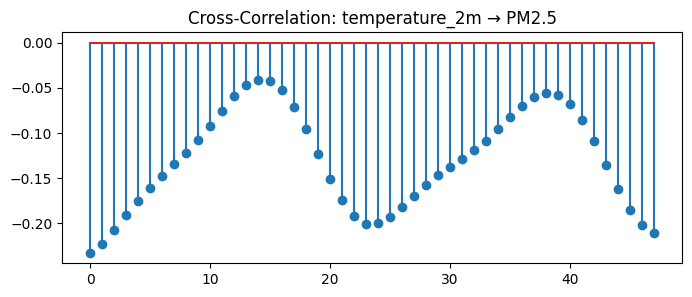

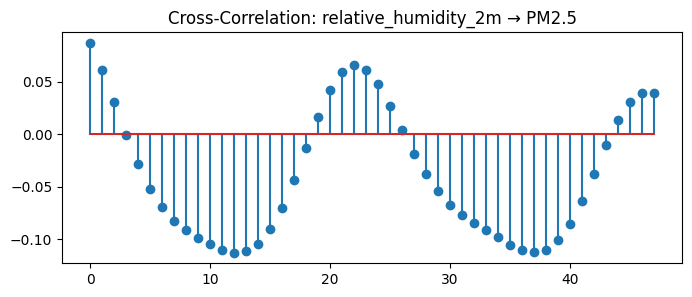

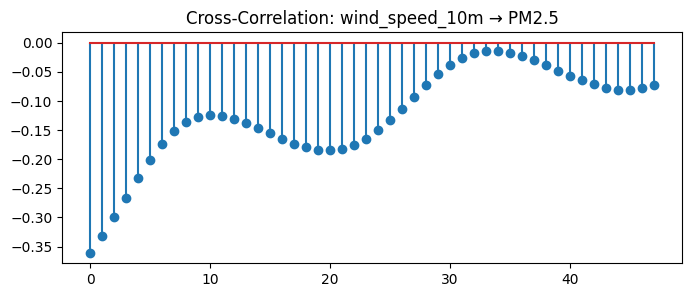

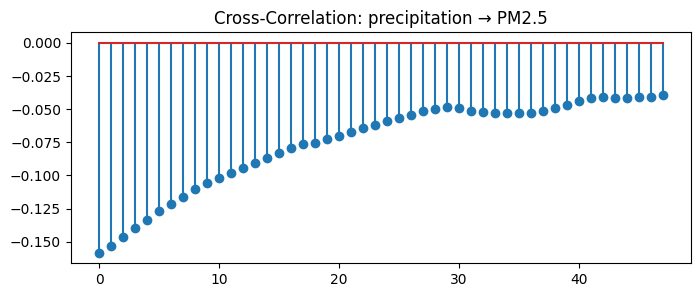

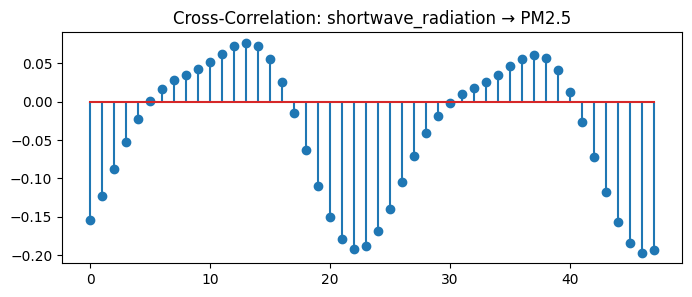

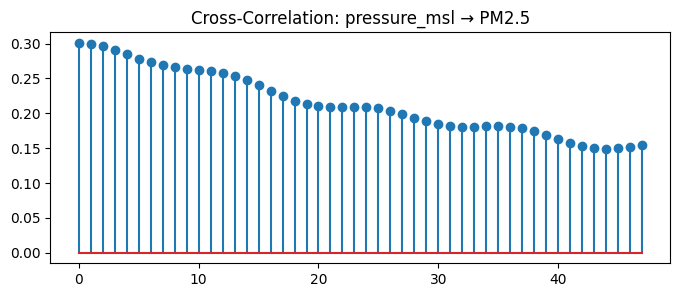

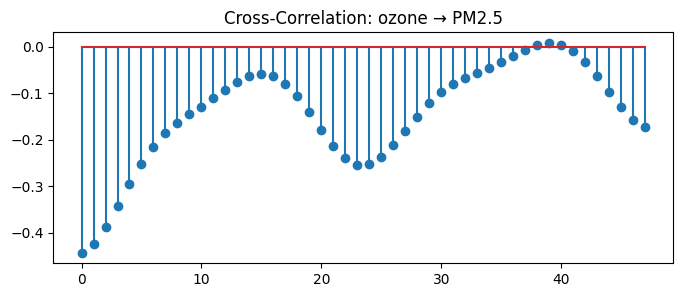

In [24]:
for var in exog_vars:
    c = ccf(df[var], df[target])[:48]
    plt.figure(figsize=(8,3))
    plt.stem(c)
    plt.title(f"Cross-Correlation: {var} → PM2.5")
    plt.show()


#### *RESULTS:*

1. **Temperature → PM2.5**

Higher temperatures reduce PM2.5 — consistent with atmospheric physics.
The effect is almost immediate (lag 0–3h).
The sinusoidal component proves that temperature and PM2.5 vary in daily cycles.

2. **Relative Humidity → PM2.5**

In short lags: higher humidity → lower PM2.5 (probable deposition/removal effect).
In long lags: higher humidity coincides with colder hours of the day, leading to PM2.5 (thermal inversions).

3. **Wind Speed → PM2.5**

Wind disperses particles → PM2.5
Strong and immediate impact (short lag).
The smooth curve indicates very stable and predictable behavior throughout the day.

4. **Precipitation → PM2.5**

Rain cleans particles (scavenging effect).
Nonlinear relationship and less dependent on the time of day.

5. **Shortwave Radiation → PM2.5**

Solar radiation increases vertical mixing → PM2.5
Very clear photodaily cycle
Highly seasonal variable

6. **Pressure MSL → PM2.5**

High pressure → stable air → PM2.5 ↑
Pressure reflects weather systems (air masses)
Impact spread over hours and days.

7. **Ozone → PM2.5**

High O₃ indicates strong photocatalysis → vertical mixing → decrease in PM2.5
Very stable relationship throughout the day
Very significant effect


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[exog_vars].dropna()

vif = pd.DataFrame()
vif["Variable"] = exog_vars
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(exog_vars))]
vif


,Variable,VIF
0,temperature_2m,16.847720
1,relative_humidity_2m,45.576696
2,wind_speed_10m,5.514189
3,precipitation,1.268922
4,shortwave_radiation,3.035031
5,pressure_msl,78.706145
6,ozone,10.442221


The results showed severe multicollinearity for relative_humidity_2m (VIF ≈ 45.6) and pressure_msl (VIF ≈ 78.7). According to standard econometric thresholds (VIF > 10), these variables were removed from the SARIMAX model.

In [73]:
train = df_total.loc['2020-11-20':'2025-05-20']
test  = df_total.loc['2025-05-21':'2025-11-20']

train_y = train[target]
test_y  = test[target]

train_exog = train[exog_vars]
test_exog  = test[exog_vars]

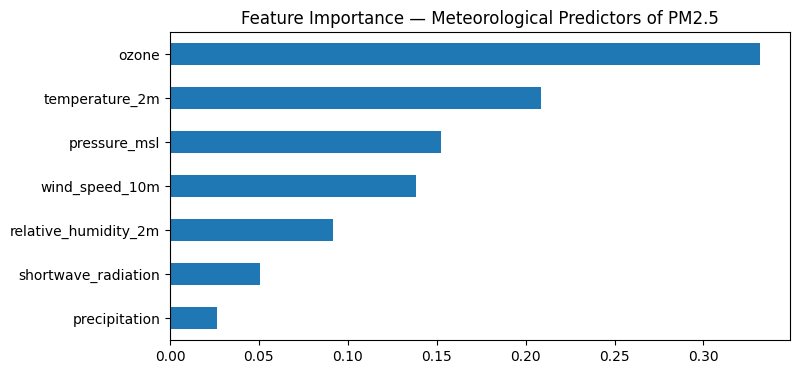

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train_exog, train_y)

importances = pd.Series(rf.feature_importances_, index=exog_vars)
importances.sort_values().plot(kind='barh', figsize=(8,4))
plt.title("Feature Importance — Meteorological Predictors of PM2.5")
plt.show()


The feature importance graph shows that:

- Ozone, Temperature, Pressure, and Wind Speed are the main meteorological drivers of PM2.5.

- Shortwave radiation and Humidity have some relevance but are more moderate.

- Precipitation has a limited impact, as expected due to the low frequency of these events.

The Random Forest model confirms the previous analysis, strengthening the theoretical and analytical basis.

## Transformations

In [75]:
import numpy as np
train_y = np.log(train["pm2_5"])
test_y  = np.log(test["pm2_5"])


## Stationarity tests (ADF + KPSS)

In [40]:
from statsmodels.tsa.stattools import adfuller, kpss

print("ADF:", adfuller(train_y))
print("KPSS:", kpss(train_y, regression="c"))


ADF: (np.float64(-14.779818642336245), np.float64(2.2545464922301123e-27), 54, 39377, {'1%': np.float64(-3.4305160798522154), '5%': np.float64(-2.8616134034474574), '10%': np.float64(-2.5668090703033766)}, np.float64(-50604.4389379192))
KPSS: (np.float64(0.289824826132606), np.float64(0.1), 109, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/var/folders/lj/bqp9twns70b7kv9_5lv4t5bc0000gn/T/ipykernel_70912/449581536.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS:", kpss(train_y, regression="c"))


At the ADF level, we conclude that:

- The statistical value is much more negative than the critical value at 1% (–3.43).
- The p-value is extremely small (2 × 10⁻²⁷).

Therefore, according to the ADF, the log(PM2.5) series is **stationary.**

At the KPSS level:

- The statistical value (0.2898) is below the critical value at 10% (0.347)
- The p-value (0.1) is the maximum in the table, which means that the true p-value is even higher.

Therefore, according to the KPSS, the log(PM2.5) series is **stationary.**

## Identify Differencing (d) e Seasonal Differencing (D)

Since our series is already stationary, then:

d = 0,
D = 0

## Identify ACF e PACF para identificar p, q, P, Q

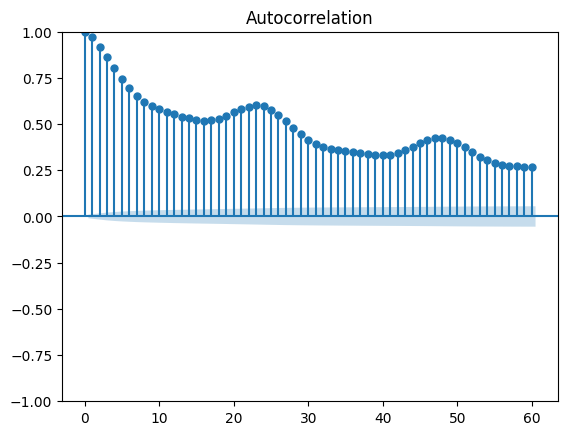

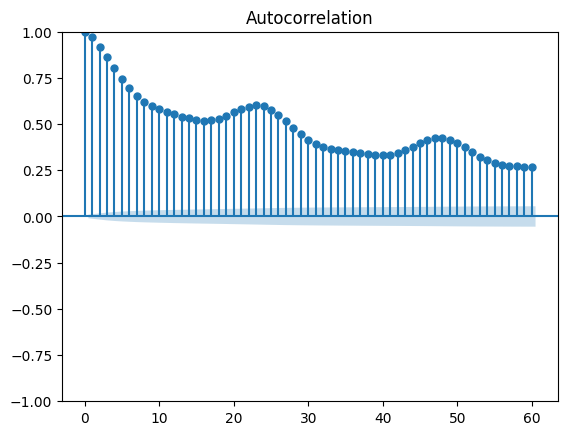

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_y, lags=60)

- Lag 1: close to 1
- Lags up to 60: autocorrelation still quite high
- Smooth downward trend → typical of undifferentiated series, but already stationary after log transformation
- Mostra ondas cíclicas com picos por volta dos lag 24 e 48: Logo: sazonalidade de 24h
- Podemos observar uma descida suave indicando, comportamento típico de AR.
- O termo MA pode existir mas fraco, q = 0 ou q = 1.
- Devido a sazonalidade P = 1 e Q = 1.

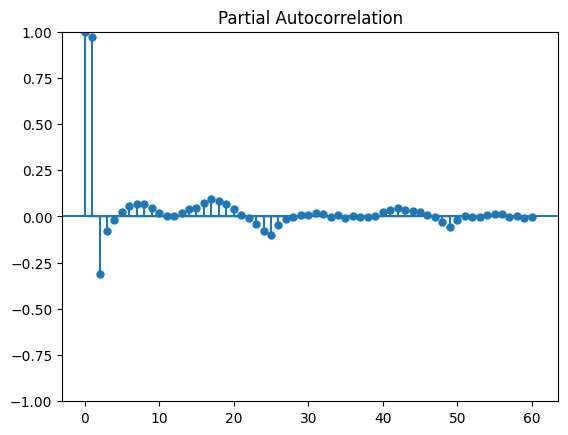

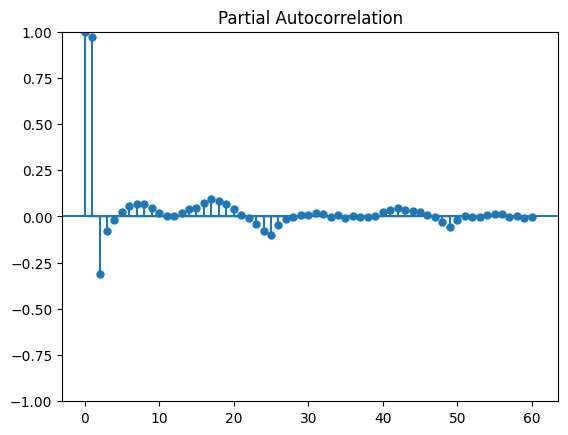

In [47]:
plot_pacf(train_y, lags=60)

- lag 1 and 2 significativos e depois tudo cai para perto de 0, portanto p = 1 ou p = 2

## Train Models

Model selection will be performed using the Akaike Information Criterion (AIC), which balances model fit and complexity.
Several SARIMAX candidate models were fitted using different combinations of (p, q) and (P, Q) orders, and the model with the lowest AIC will be selected.

In [50]:
exog_vars_sarimax = [
    "temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "ozone"
]

p_values = [1, 2]
q_values = [0, 1]
d_values = [0]
P_values = [1]
Q_values = [1]
d = 0
D = 0
s = 24

### ARIMA

In [53]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order_arima = None
best_model_arima = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_y, order=(p,d,q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order_arima = (p,d,q)
            best_model_arima = model
        print(f"ARIMA{(p,d,q)} → AIC = {model.aic}")
    except:
        continue

print("\nBest ARIMA:", best_order_arima, "AIC:", best_aic)


ARIMA(1, 0, 0) → AIC = -43323.93489080371
ARIMA(1, 0, 1) → AIC = -46610.50309059533
ARIMA(2, 0, 0) → AIC = -47376.057979816134
ARIMA(2, 0, 1) → AIC = -47608.39360783473

Best ARIMA: (2, 0, 1) AIC: -47608.39360783473


### SARIMA

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

results = []

for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    try:
        model = SARIMAX(train_y,
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,s),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

        results.append({
            "order": (p,d,q),
            "seasonal": (P,D,Q,s),
            "AIC": model.aic
        })

        print(f"SARIMA{(p,d,q)}({P,D,Q,s}) → AIC = {model.aic}")

    except Exception as e:
        print(f"Failed: {(p,d,q),(P,D,Q,s)}")

results_df = pd.DataFrame(results).sort_values("AIC")
print("\nBest models:")
print(results_df.head())


SARIMA(1, 0, 0)((1, 0, 1, 24)) → AIC = -49154.088491831615
SARIMA(1, 0, 1)((1, 0, 1, 24)) → AIC = -50797.71407996121
SARIMA(2, 0, 0)((1, 0, 1, 24)) → AIC = -51017.180373471536


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)((1, 0, 1, 24)) → AIC = -51108.83250679035

Best models:
       order       seasonal           AIC
3  (2, 0, 1)  (1, 0, 1, 24) -51108.832507
2  (2, 0, 0)  (1, 0, 1, 24) -51017.180373
1  (1, 0, 1)  (1, 0, 1, 24) -50797.714080
0  (1, 0, 0)  (1, 0, 1, 24) -49154.088492


In [57]:
best = results_df.iloc[0]
best_order_sarima = best["order"]
best_seasonal_sarima = best["seasonal"]

print("Best SARIMA:", best_order_sarima, best_seasonal_sarima)

best_model_sarima = SARIMAX(
    train_y,
    order=best_order_sarima,
    seasonal_order=best_seasonal_sarima,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()


Best SARIMA: (2, 0, 1) (1, 0, 1, 24)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.59131D-01    |proj g|=  1.91353D+00

At iterate    5    f= -5.27742D-01    |proj g|=  3.36956D-01

At iterate   10    f= -6.09699D-01    |proj g|=  5.95355D-01

At iterate   15    f= -6.14318D-01    |proj g|=  8.32584D-02

At iterate   20    f= -6.15417D-01    |proj g|=  4.07770D-01

At iterate   25    f= -6.23172D-01    |proj g|=  8.38568D-01

At iterate   30    f= -6.43865D-01    |proj g|=  4.39172D-01

At iterate   35    f= -6.48186D-01    |proj g|=  1.06782D-02

At iterate   40    f= -6.48188D-01    |proj g|=  1.45544D-02

At iterate   45    f= -6.48212D-01    |proj g|=  5.15587D-02


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.48215D-01    |proj g|=  1.60308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   1.603D-04  -6.482D-01
  F = -0.64821506018957131     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


### SARIMAX

In [61]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_values = [1, 2]
q_values = [0, 1]
P_values = [1]
Q_values = [1]
d = 0
D = 0
s = 24

results = []


for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    try:
        model = SARIMAX(
            train_y,
            exog=train[exog_vars_sarimax],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        results.append({
            "order": (p, d, q),
            "seasonal_order": (P, D, Q, s),
            "AIC": model.aic
        })

        print(f"Model {(p,d,q),(P,D,Q,s)} - AIC: {model.aic}")

    except Exception as e:
        print(f"Model {(p,d,q),(P,D,Q,s)} failed: {e}")

# Sort results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("AIC")
results_df

/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ((1, 0, 0), (1, 0, 1, 24)) - AIC: -46823.70305589301


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ((1, 0, 1), (1, 0, 1, 24)) - AIC: -50115.41731289187


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ((2, 0, 0), (1, 0, 1, 24)) - AIC: -47871.79646557856


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ((2, 0, 1), (1, 0, 1, 24)) - AIC: -50087.665236956


,order,seasonal_order,AIC
1,"(1, 0, 1)","(1, 0, 1, 24)",-50115.417313
3,"(2, 0, 1)","(1, 0, 1, 24)",-50087.665237
2,"(2, 0, 0)","(1, 0, 1, 24)",-47871.796466
0,"(1, 0, 0)","(1, 0, 1, 24)",-46823.703056


In [63]:
best = results_df.iloc[0]
best_order = best["order"]
best_seasonal = best["seasonal_order"]

print("Best SARIMAX:", best_order, best_seasonal)

best_model = SARIMAX(
    train_y,
    exog=train[exog_vars_sarimax],
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()


Best SARIMAX: (1, 0, 1) (1, 0, 1, 24)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.19346D-02    |proj g|=  3.68326D+01


 This problem is unconstrained.



At iterate    5    f= -2.06165D-01    |proj g|=  2.69549D+01

At iterate   10    f= -2.94388D-01    |proj g|=  1.99639D+01

At iterate   15    f= -4.73786D-01    |proj g|=  6.03810D+00

At iterate   20    f= -5.35484D-01    |proj g|=  1.04537D+01

At iterate   25    f= -5.65542D-01    |proj g|=  3.64929D+00

At iterate   30    f= -5.79019D-01    |proj g|=  1.57590D+00

At iterate   35    f= -5.91886D-01    |proj g|=  3.46038D+00

At iterate   40    f= -5.99700D-01    |proj g|=  1.01487D+00

At iterate   45    f= -6.08513D-01    |proj g|=  2.57848D+00


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.35720D-01    |proj g|=  8.07705D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   8.077D-01  -6.357D-01
  F = -0.63571993955279815     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


### XGBoost

In [34]:
features = df_total.columns.tolist()
features.remove('pm2_5')

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Correlação
corr = df_total[features + ['pm2_5']].corr()['pm2_5'].abs().reindex(features)

# Random Forest
rf = RandomForestRegressor()
rf.fit(df_total[features], df_total['pm2_5'])
rf_imp = pd.Series(rf.feature_importances_, index=features)

# XGBoost
xgb = XGBRegressor()
xgb.fit(df_total[features], df_total['pm2_5'])
xgb_imp = pd.Series(xgb.feature_importances_, index=features)

# MI
mi = mutual_info_regression(df_total[features], df_total['pm2_5'])
mi_imp = pd.Series(mi, index=features)

# Combine everything
feature_scores = pd.DataFrame({
    'corr': corr,
    'rf': rf_imp,
    'xgb': xgb_imp,
    'mi': mi_imp
})

# Composite score
feature_scores['score'] = (
    0.35 * corr.rank(ascending=False) +
    0.25 * rf_imp.rank(ascending=False) +
    0.25 * xgb_imp.rank(ascending=False) +
    0.15 * mi_imp.rank(ascending=False)
)

best_features = feature_scores.sort_values('score').index[:12].tolist()

best_features


['pm10',
 'carbon_monoxide',
 'nitrogen_dioxide',
 'sulphur_dioxide',
 'dust',
 'ozone',
 'wind_speed_10m',
 'wind_direction_10m',
 'pressure_msl',
 'surface_pressure',
 'temperature_2m',
 'dew_point_2m']

In [35]:
def create_lags(df, features, max_lag=24):
    df = df.copy()

    lag_frames = []

    for lag in range(1, max_lag + 1):
        shifted = df[features].shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in shifted.columns]
        lag_frames.append(shifted)

    # Concatenar tudo de uma vez
    df_lags = pd.concat([df] + lag_frames, axis=1)

    return df_lags

train_ml = create_lags(train, best_features)
test_ml  = create_lags(test, best_features)

In [36]:
train_ml = train_ml.dropna()
test_ml = test_ml.dropna()

In [37]:
X_train = train_ml.drop(columns=[target])
y_train = train_ml[target]

X_test = test_ml.drop(columns=[target])
y_test = test_ml[target]

In [38]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist"
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse:.3f}")
print(f"XGBoost MAE: {mae:.3f}")


XGBoost RMSE: 2.185
XGBoost MAE: 1.477


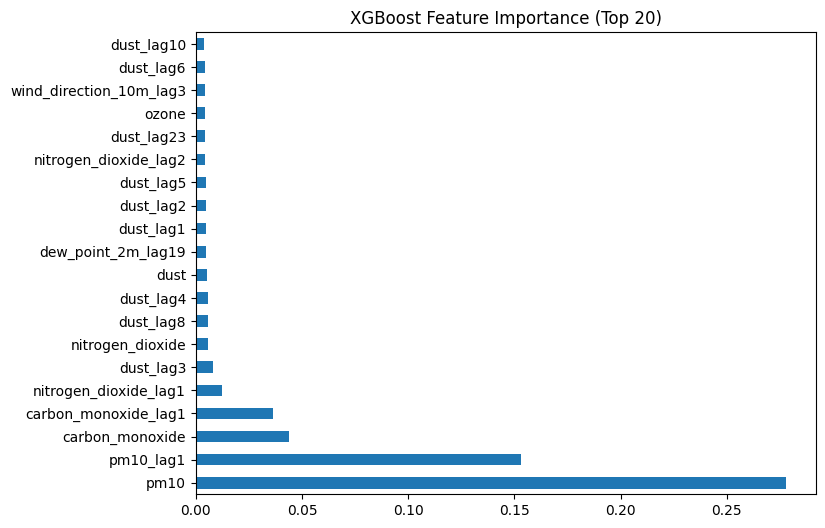

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

importance = pd.Series(xgb.feature_importances_, index=X_train.columns)
importance.nlargest(20).plot(kind='barh', figsize=(8,6))
plt.title("XGBoost Feature Importance (Top 20)")
plt.show()


### LSTM

In [41]:
def add_lags(df, features, max_lag=24):
    df = df.copy()
    lag_frames = []

    for lag in range(1, max_lag + 1):
        shifted = df[features].shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in shifted.columns]
        lag_frames.append(shifted)

    df_lags = pd.concat([df] + lag_frames, axis=1)

    return df_lags


train_lstm = add_lags(train, best_features, max_lag=24).dropna()
test_lstm  = add_lags(test, best_features, max_lag=24).dropna()

In [42]:
X_train = train_lstm.drop(columns=[target])
y_train = train_lstm[target]

X_test  = test_lstm.drop(columns=[target])
y_test  = test_lstm[target]

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [44]:
import numpy as np

def create_sequences(X, y, window=24):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window = 24

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, window)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, window)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

model.summary()


/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        96,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,217 (426.63 KB)

 Trainable params: 109,217 (426.63 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=25,
    batch_size=64,
    verbose=1
)

Epoch 1/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 60.1390 - val_loss: 21.8139
Epoch 2/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 11.4557 - val_loss: 15.1050
Epoch 3/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 9.0101 - val_loss: 12.3051
Epoch 4/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 7.6580 - val_loss: 13.4123
Epoch 5/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 7.0076 - val_loss: 15.4967
Epoch 6/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 6.5661 - val_loss: 11.9924
Epoch 7/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 6.1575 - val_loss: 14.8986
Epoch 8/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 5.6432 - val_loss: 14.1718
Epoch 9/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 5.1986 - val_loss: 13.7059
Epoch 10/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.8858 - val_loss: 13.7109
Epoch 11/25
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 4.8057 - val_loss: 13.1989
Epoch 12/25
554/554 ━━━

### Temporal Convolution (TCN)

In [48]:
# TODO: MAIS RECENTE, PODEMOS TAMBEM TESTAR DEPOIS

## Model Diagnosis

### ARIMA

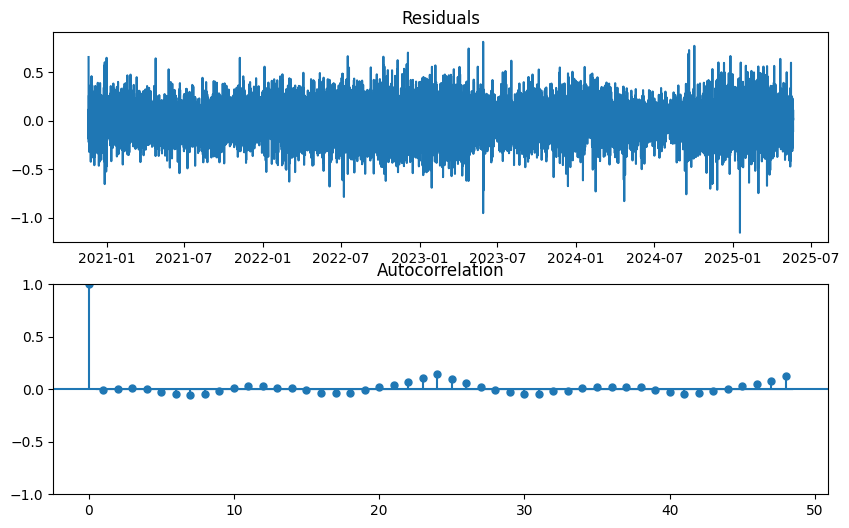

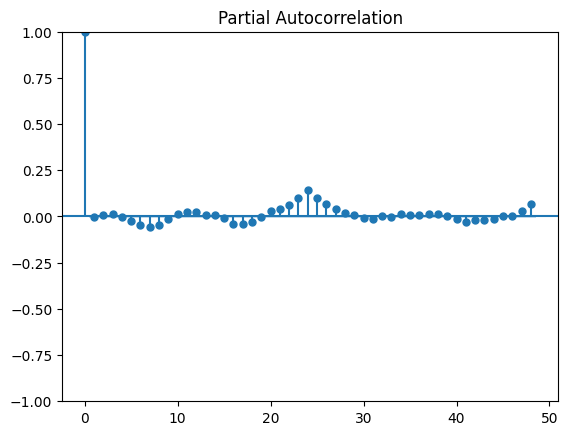

In [54]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

resid = best_model_arima.resid

fig, ax = plt.subplots(2, 1, figsize=(10,6))

ax[0].plot(resid)
ax[0].set_title("Residuals")

sm.graphics.tsa.plot_acf(resid, lags=48, ax=ax[1])
plt.show()

sm.graphics.tsa.plot_pacf(resid, lags=48)
plt.show()


#### Ljung-Box Test

In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[24, 36], return_df=True)
print(lb)


        lb_stat  lb_pvalue
24  2185.468354        0.0
36  2962.456498        0.0


### SARIMA

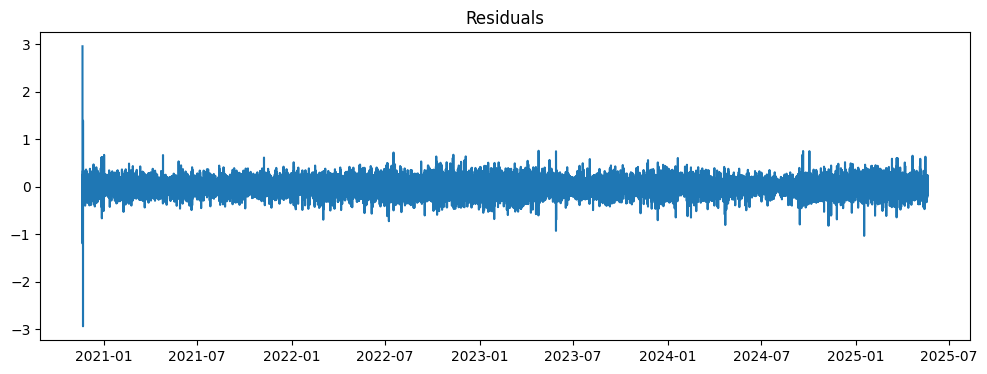

In [58]:
resid = best_model_sarima.resid

plt.figure(figsize=(12,4))
plt.plot(resid)
plt.title("Residuals")
plt.show()


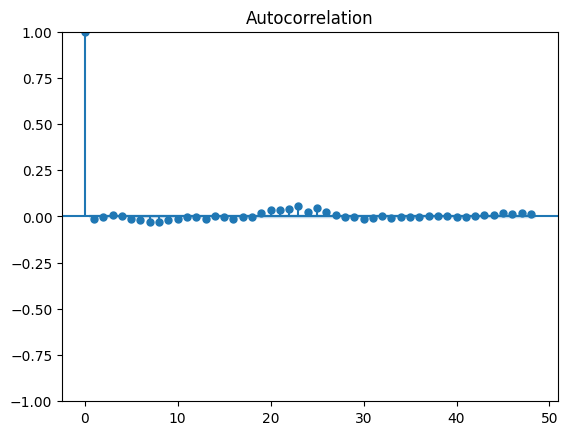

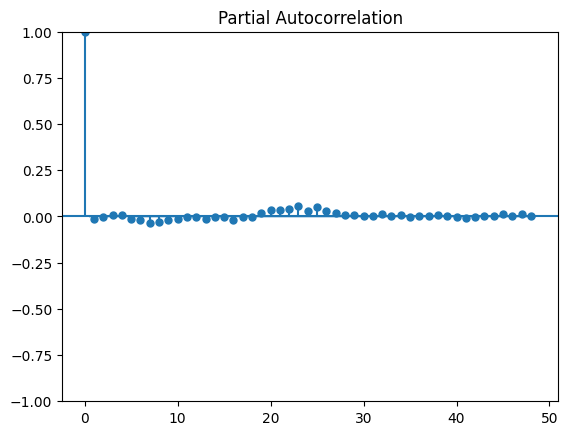

In [59]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(resid, lags=48)
plt.show()

sm.graphics.tsa.plot_pacf(resid, lags=48)
plt.show()


In [60]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[24, 48], return_df=True)
print(lb)


       lb_stat      lb_pvalue
24  465.812166   2.036678e-83
48  640.572873  1.407704e-104


### SARIMAX

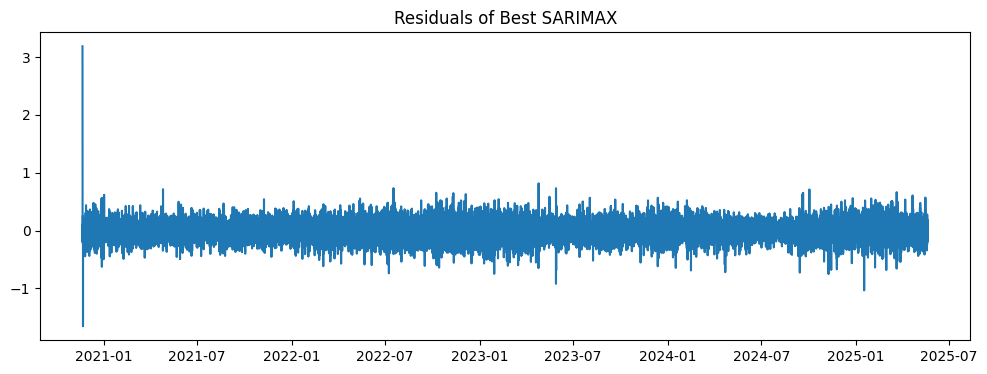

In [64]:
resid = best_model.resid

plt.figure(figsize=(12,4))
plt.plot(resid)
plt.title("Residuals of Best SARIMAX")
plt.show()


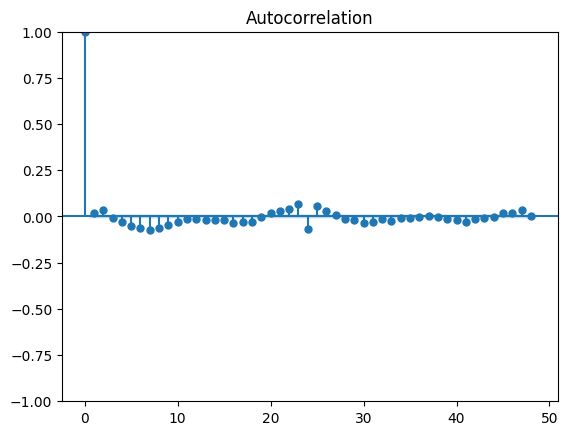

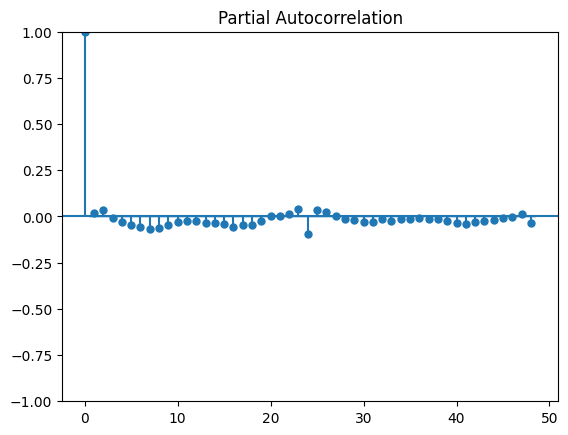

In [65]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(resid, lags=48)
plt.show()

sm.graphics.tsa.plot_pacf(resid, lags=48)
plt.show()


In [66]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[24, 48], return_df=True)
print(lb)


        lb_stat      lb_pvalue
24  1443.561991  2.412464e-290
48  1901.639818   0.000000e+00


In [78]:
steps = len(test_y)

forecast = best_model.predict(
    start=len(train_y),
    end=len(train_y) + steps - 1,
    exog=test[exog_vars_sarimax]
)


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_y, forecast))
mae = mean_absolute_error(test_y, forecast)

print("SARIMAX RMSE:", rmse)
print("SARIMAX MAE:", mae)


SARIMAX RMSE: 2.43949787825711
SARIMAX MAE: 2.310945575791823


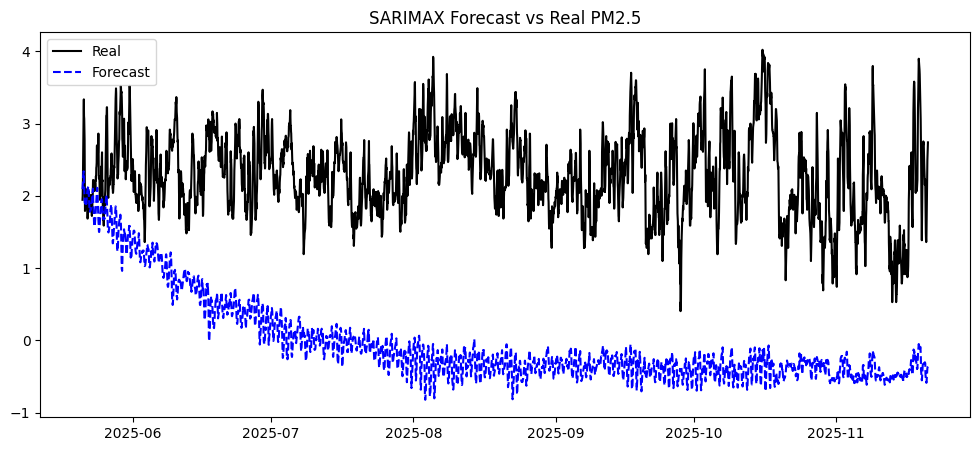

In [87]:
plt.figure(figsize=(12,5))
plt.plot(test_y.index, test_y, label="Real", color='black')
plt.plot(test_y.index, forecast, label="Forecast", linestyle="--", color='blue')
plt.title("SARIMAX Forecast vs Real PM2.5")
plt.legend()
plt.show()


## Test Models

In [ ]:
y_pred_lstm = model.predict(X_test_seq).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
mae = mean_absolute_error(y_test_seq, y_pred_lstm)

print(f"LSTM RMSE: {rmse:.3f}")
print(f"LSTM MAE: {mae:.3f}")


## Time series cross-validation

## Results

## Conclusion